In [59]:
#CELL 1 — Imports & Config

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    auc
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "patient_data.csv"
RANDOM_STATE = 42


In [60]:
#CELL 2 — Load Dataset
df = pd.read_csv(DATA_PATH)

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (50000, 9)


,age,gender,diagnosis_code,procedures,lab_result,length_of_stay,prev_admissions,discharge_type,readmitted
0,69,F,D2,1,77.658279,10,3,Home,1
1,32,M,D1,0,111.360511,13,1,Home,0
2,89,M,D1,1,115.286626,6,1,Nursing,1
3,78,M,D1,6,98.750401,6,1,Home,0
4,38,F,D8,3,106.281126,13,3,Home,1



Missing Values:
 age                0
gender             0
diagnosis_code     0
procedures         0
lab_result         0
length_of_stay     0
prev_admissions    0
discharge_type     0
readmitted         0
dtype: int64

Class Distribution (0 = No Readmission, 1 = Readmission):
readmitted
0    0.74752
1    0.25248
Name: proportion, dtype: float64


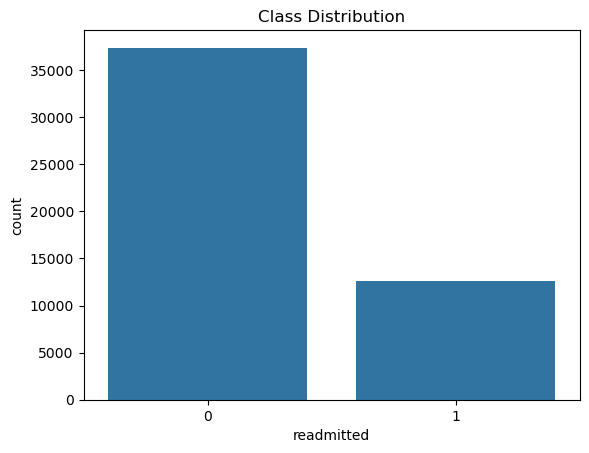

In [61]:
#CELL 3 — Basic EDA
print("\nMissing Values:\n", df.isnull().sum())

print("\nClass Distribution (0 = No Readmission, 1 = Readmission):")
print(df["readmitted"].value_counts(normalize=True))

sns.countplot(x="readmitted", data=df)
plt.title("Class Distribution")
plt.show()

In [62]:
#CELL 4 — Features & Target
X = df.drop("readmitted", axis=1)
y = df["readmitted"]

categorical_features = ["gender", "diagnosis_code", "discharge_type"]
numerical_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [63]:
#CELL 5 — Train / Validation / Test Split We’ll do:70% Train 15% Validation 15% Test

# First split: Train + Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_STATE
)

# Second split: Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (35000, 8)
Validation size: (7500, 8)
Test size: (7500, 8)


In [64]:
#CELL 6 — Preprocess & SMOTE (ONLY ON TRAIN)
# Fit on TRAIN only
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE only on training data
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_processed, y_train
)

print("After SMOTE class balance:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))

After SMOTE class balance:
readmitted
0    0.5
1    0.5
Name: proportion, dtype: float64


In [65]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train_balanced.value_counts()[0] / 
                      y_train_balanced.value_counts()[1]),
    eval_metric="auc",
    random_state=RANDOM_STATE
)

model.fit(X_train_balanced, y_train_balanced)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [66]:
#CELL 8 — Validation Evaluation (Model Selection Step)

y_val_pred = model.predict(X_val_processed)
y_val_prob = model.predict_proba(X_val_processed)[:, 1]

print("VALIDATION REPORT\n")
print(classification_report(y_val, y_val_pred))

val_auroc = roc_auc_score(y_val, y_val_prob)
print("Validation AUROC:", round(val_auroc, 4))


VALIDATION REPORT

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      5606
           1       0.00      0.00      0.00      1894

    accuracy                           0.75      7500
   macro avg       0.37      0.50      0.43      7500
weighted avg       0.56      0.75      0.64      7500

Validation AUROC: 0.5068


In [67]:
#CELL 9 — Final Test Evaluation (Unbiased Performance)
y_test_pred = model.predict(X_test_processed)
y_test_prob = model.predict_proba(X_test_processed)[:, 1]

print("TEST REPORT\n")
print(classification_report(y_test, y_test_pred))

test_auroc = roc_auc_score(y_test, y_test_prob)
print("Test AUROC:", round(test_auroc, 4))

TEST REPORT

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      5607
           1       0.50      0.00      0.00      1893

    accuracy                           0.75      7500
   macro avg       0.62      0.50      0.43      7500
weighted avg       0.69      0.75      0.64      7500

Test AUROC: 0.5168


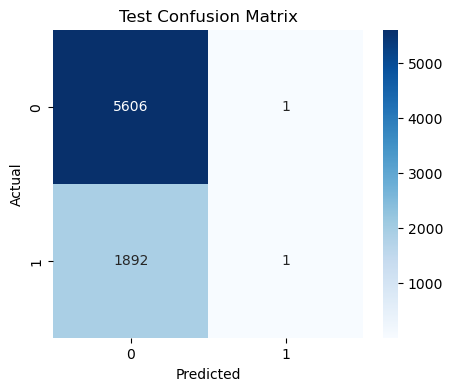

In [68]:
#CELL 10 — Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

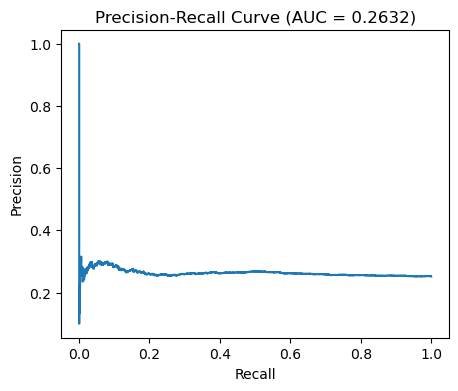

In [69]:
#CELL 11 — Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve (AUC = {round(pr_auc, 4)})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


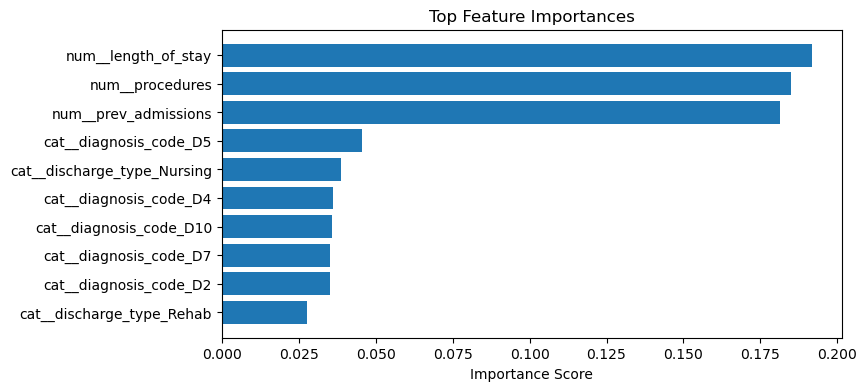

In [70]:
#CELL 12 — Feature Importance (Explainability)
feature_names = preprocessor.get_feature_names_out()
importances = model.feature_importances_

indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8, 4))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title("Top Feature Importances")
plt.xlabel("Importance Score")
plt.show()

In [71]:
from sklearn.metrics import accuracy_score

# Training performance
y_train_pred = model.predict(X_train_balanced)
train_acc = accuracy_score(y_train_balanced, y_train_pred)

# Validation performance
y_val_pred = model.predict(X_val_processed)
val_acc = accuracy_score(y_val, y_val_pred)

print("Training Accuracy:", round(train_acc, 4))
print("Validation Accuracy:", round(val_acc, 4))


Training Accuracy: 0.807
Validation Accuracy: 0.7472
